In [1]:
import random as rnd
import functools as func
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

In [2]:
import pandas as pd

In [3]:
data_prefix = "M5/"
data_path = "sales_train_validation.csv"
data = pd.read_csv(data_path)
data1 = data.iloc[:,6:]
arr = np.array(data1)
tt = torch.tensor(arr)
print(tt.shape)
tt2=torch.tensor(data1.values)
print(tt2.shape)

torch.Size([30490, 1913])
torch.Size([30490, 1913])


In [4]:
s = np.array([i for i in map(lambda d: sum(d)/1941.0, data1.values)])
m = np.array([i for i in map(lambda d: max(d), data1.values)])

In [5]:
data2 = data1[s>10]
m1 = m[s>10]
data2

d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  ...  d_1904  d_1905  \
339      9   24    0    0    7    8    0    3    0     7  ...       2       4   
362     14   25   67   27    0   74   13   32   15     4  ...       6      20   
1695    10   15   13    5   11    5    7   21    6     6  ...      12      14   
1826    10    3    4    0    0    0    1    4    2     0  ...      10       3   
1846    15   27   18   29   23   20    2    2   44    14  ...      15      15   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...     ...     ...   
30375   57   31   18   31   31   52   40   76   39    26  ...      35      14   
30378   47   38   28   27   23   32   33   52   33    33  ...      31      40   
30387   40   47   18   18   17   46   54  104   77     8  ...      30      37   
30414   32   48   91   39   19    1   74   88   19     0  ...      29      16   
30470    4   13    5    1    5    0    2    4    6     7  ...       0       0   

       d_1906  d_1907  d_1908  d_1909  d_1910  d_1911  d_1912  d_1913  
339         1       2      11       5       8       1      11      26  
362         4      15      13      28      16      15       1       2  
1695        6       5       6       9      20      14       5       9  
1826       10       9       5       4       2       9       8       6  
1846       30      17       9      17      13      13      26      22  
...       ...     ...     ...     ...     ...     ...     ...     ...  
30375      14      18       8       1       2       9       8      10  
30378      10      20      18      16      25      26      36      20  
30387      38      21      15      24      16      27      42      41  
30414      12      21      15       5       8       9      16      11  
30470       0       0       0       0       0       0       0       0  

[357 rows x 1913 columns]

In [6]:
tt2=torch.tensor(data2.values)
m2t = torch.unsqueeze(torch.tensor(m1), 1)
#tt2=tt2/(m2t)
print(tt2.shape)
#print(m2t)
tt2=tt2.transpose(0,1)
print(tt2.shape)
tta = tt2.numpy()
np.savetxt("M5.txt", tta, delimiter=',')

torch.Size([357, 1913])
torch.Size([1913, 357])


In [7]:
tta

array([[ 9, 14, 10, ..., 40, 32,  4],
       [24, 25, 15, ..., 47, 48, 13],
       [ 0, 67, 13, ..., 18, 91,  5],
       ...,
       [ 1, 15, 14, ..., 27,  9,  0],
       [11,  1,  5, ..., 42, 16,  0],
       [26,  2,  9, ..., 41, 11,  0]], dtype=int64)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, args, data):
        super(Model, self).__init__()
        self.use_cuda = args.cuda
        self.P = args.window;
        self.m = data.m
        self.hidR = args.hidRNN;
        self.hidC = args.hidCNN;
        self.hidS = args.hidSkip;
        self.Ck = args.CNN_kernel;
        self.skip = args.skip;
        self.pt = int((self.P - self.Ck)/self.skip)
        self.hw = args.highway_window
        self.conv1 = nn.Conv2d(1, self.hidC, kernel_size = (self.Ck, self.m));
        self.GRU1 = nn.GRU(self.hidC, self.hidR);
        self.dropout = nn.Dropout(p = args.dropout);
        if (self.skip > 0):
            self.GRUskip = nn.GRU(self.hidC, self.hidS);
            self.linear1 = nn.Linear(self.hidR + self.skip * self.hidS, self.m);
        else:
            self.linear1 = nn.Linear(self.hidR, self.m);
        if (self.hw > 0):
            self.highway = nn.Linear(self.hw, 1);
        self.output = None;
        if (args.output_fun == 'sigmoid'):
            self.output = F.sigmoid;
        if (args.output_fun == 'tanh'):
            self.output = F.tanh;
 
    def forward(self, x):
        batch_size = x.size(0);
        
        #CNN
        c = x.view(-1, 1, self.P, self.m);
        c = F.relu(self.conv1(c));
        c = self.dropout(c);
        c = torch.squeeze(c, 3);
        
        # RNN 
        r = c.permute(2, 0, 1).contiguous();
        _, r = self.GRU1(r);
        r = self.dropout(torch.squeeze(r,0));

        
        #skip-rnn
        
        if (self.skip > 0):
            s = c[:,:, int(-self.pt * self.skip):].contiguous();
            s = s.view(batch_size, self.hidC, self.pt, self.skip);
            s = s.permute(2,0,3,1).contiguous();
            s = s.view(self.pt, batch_size * self.skip, self.hidC);
            _, s = self.GRUskip(s);
            s = s.view(batch_size, self.skip * self.hidS);
            s = self.dropout(s);
            r = torch.cat((r,s),1);
        
        res = self.linear1(r);
        
        #highway
        if (self.hw > 0):
            z = x[:, -self.hw:, :];
            z = z.permute(0,2,1).contiguous().view(-1, self.hw);
            z = self.highway(z);
            z = z.view(-1,self.m);
            res = res + z;
            
        if (self.output):
            res = self.output(res);
        return res;
    
        
        

In [9]:
import math
import torch.optim

class Optim(object):

    def _makeOptimizer(self):
        if self.method == 'sgd':
            self.optimizer = torch.optim.SGD(self.params, lr=self.lr)
        elif self.method == 'adagrad':
            self.optimizer = torch.optim.Adagrad(self.params, lr=self.lr)
        elif self.method == 'adadelta':
            self.optimizer = torch.optim.Adadelta(self.params, lr=self.lr)
        elif self.method == 'adam':
            self.optimizer = torch.optim.Adam(self.params, lr=self.lr)
        else:
            raise RuntimeError("Invalid optim method: " + self.method)

    def __init__(self, params, method, lr, max_grad_norm, lr_decay=1, start_decay_at=None):
        self.params = list(params)  # careful: params may be a generator
        self.last_ppl = None
        self.lr = lr
        self.max_grad_norm = max_grad_norm
        self.method = method
        self.lr_decay = lr_decay
        self.start_decay_at = start_decay_at
        self.start_decay = False

        self._makeOptimizer()

    def step(self):
        # Compute gradients norm.
        grad_norm = 0
        for param in self.params:
            grad_norm += math.pow(param.grad.data.norm(), 2)

        grad_norm = math.sqrt(grad_norm)
        if grad_norm > 0:
            shrinkage = self.max_grad_norm / grad_norm
        else:
            shrinkage = 1.

        for param in self.params:
            if shrinkage < 1:
                param.grad.data.mul_(shrinkage)

        self.optimizer.step()
        return grad_norm

    # decay learning rate if val perf does not improve or we hit the start_decay_at limit
    def updateLearningRate(self, ppl, epoch):
        if self.start_decay_at is not None and epoch >= self.start_decay_at:
            self.start_decay = True
        if self.last_ppl is not None and ppl > self.last_ppl:
            self.start_decay = True

        if self.start_decay:
            self.lr = self.lr * self.lr_decay
            print("Decaying learning rate to %g" % self.lr)
        #only decay for one epoch
        self.start_decay = False

        self.last_ppl = ppl

        self._makeOptimizer()

In [10]:
import torch
import numpy as np;
from torch.autograd import Variable


def normal_std(x):
    return x.std() * np.sqrt((len(x) - 1.)/(len(x)))

class Data_utility(object):
    # train and valid is the ratio of training set and validation set. test = 1 - train - valid
    def __init__(self, file_name, train, valid, cuda, horizon, window, normalize = 2, def_scale = 1):
        self.cuda = cuda;
        self.P = window;
        self.h = horizon
        fin = open(file_name);
        self.rawdat = np.loadtxt(fin,delimiter=',');
        self.dat = np.zeros(self.rawdat.shape);
        self.n, self.m = self.dat.shape;
        self.normalize = 2
        self.scale = np.ones(self.m)*def_scale;
        self._normalized(normalize);
        self._split(int(train * self.n), int((train+valid) * self.n), self.n);
        
        self.scale = torch.from_numpy(self.scale).float();
        tmp = self.test[1] * self.scale.expand(self.test[1].size(0), self.m);
            
        if self.cuda:
            self.scale = self.scale.cuda();
        self.scale = Variable(self.scale);
        
        self.rse = normal_std(tmp);
        self.rae = torch.mean(torch.abs(tmp - torch.mean(tmp)));
    
    def _normalized(self, normalize):
        #normalized by the maximum value of entire matrix.
       
        if (normalize == 0):
            self.dat = self.rawdat
            
        if (normalize == 1):
            self.dat = self.rawdat / np.max(self.rawdat);
            
        #normlized by the maximum value of each row(sensor).
        if (normalize == 2):
            for i in range(self.m):
                self.scale[i] = np.max(np.abs(self.rawdat[:,i]));
                self.dat[:,i] = self.rawdat[:,i] / np.max(np.abs(self.rawdat[:,i]));
            
        
    def _split(self, train, valid, test):
        
        train_set = range(self.P+self.h-1, train);
        valid_set = range(train, valid);
        test_set = range(valid, self.n);
        self.train = self._batchify(train_set, self.h);
        self.valid = self._batchify(valid_set, self.h);
        self.test = self._batchify(test_set, self.h);
        
        
    def _batchify(self, idx_set, horizon):
        
        n = len(idx_set);
        X = torch.zeros((n,self.P,self.m));
        Y = torch.zeros((n,self.m));
        
        for i in range(n):
            end = idx_set[i] - self.h + 1;
            start = end - self.P;
            X[i,:,:] = torch.from_numpy(self.dat[start:end, :]);
            Y[i,:] = torch.from_numpy(self.dat[idx_set[i], :]);

        return [X, Y];

    def get_batches(self, inputs, targets, batch_size, shuffle=True):
        length = len(inputs)
        if shuffle:
            index = torch.randperm(length)
        else:
            index = torch.LongTensor(range(length))
        start_idx = 0
        while (start_idx < length):
            end_idx = min(length, start_idx + batch_size)
            excerpt = index[start_idx:end_idx]
            X = inputs[excerpt]; Y = targets[excerpt];
            if (self.cuda):
                X = X.cuda();
                Y = Y.cuda();  
            yield Variable(X), Variable(Y);
            start_idx += batch_size

In [11]:
import argparse
import math
import time
import sys

import torch
import torch.nn as nn

import numpy as np;
import importlib


def evaluate(data, X, Y, model, evaluateL2, evaluateL1, batch_size):
    model.eval();
    total_loss = 0;
    total_loss_l1 = 0;
    n_samples = 0;
    predict = None;
    test = None;
    
    for X, Y in data.get_batches(X, Y, batch_size, False):
        output = model(X);
        if predict is None:
            predict = output;
            test = Y;
        else:
            predict = torch.cat((predict,output));
            test = torch.cat((test, Y));
        
        scale = data.scale.expand(output.size(0), data.m)
        total_loss += evaluateL2(output * scale, Y * scale).item()
        total_loss_l1 += evaluateL1(output * scale, Y * scale).item()
        n_samples += (output.size(0) * data.m);
    rse = math.sqrt(total_loss / n_samples)/data.rse
    rae = (total_loss_l1/n_samples)/data.rae
    
    predict = predict.data.cpu().numpy();
    Ytest = test.data.cpu().numpy();
    sigma_p = (predict).std(axis = 0);
    sigma_g = (Ytest).std(axis = 0);
    mean_p = predict.mean(axis = 0)
    mean_g = Ytest.mean(axis = 0)
    index = (sigma_g!=0);
    correlation = ((predict - mean_p) * (Ytest - mean_g)).mean(axis = 0)/(sigma_p * sigma_g);
    correlation = (correlation[index]).mean();
    return rse, rae, correlation, predict, Ytest;

def train(data, X, Y, model, criterion, optim, batch_size):
    model.train();
    total_loss = 0;
    n_samples = 0;
    for X, Y in data.get_batches(X, Y, batch_size, True):
        model.zero_grad();
        output = model(X);
        scale = data.scale.expand(output.size(0), data.m)
        loss = criterion(output * scale, Y * scale);
        loss.backward();
        grad_norm = optim.step();
        total_loss += loss.item();
        n_samples += (output.size(0) * data.m);
    return total_loss / n_samples

sys.argv = "main --gpu 0 --horizon 24 --data data/electricity.txt --save save/elec.pt --output_fun Linear".split(" ")
    
parser = argparse.ArgumentParser(description='PyTorch Time series forecasting')
parser.add_argument('--data', type=str, required=True,
                    help='location of the data file')
parser.add_argument('--model', type=str, default='LSTNet',
                    help='')
parser.add_argument('--hidCNN', type=int, default=100,
                    help='number of CNN hidden units')
parser.add_argument('--hidRNN', type=int, default=100,
                    help='number of RNN hidden units')
parser.add_argument('--window', type=int, default=24 * 7,
                    help='window size')
parser.add_argument('--CNN_kernel', type=int, default=6,
                    help='the kernel size of the CNN layers')
parser.add_argument('--highway_window', type=int, default=24,
                    help='The window size of the highway component')
parser.add_argument('--clip', type=float, default=10.,
                    help='gradient clipping')
parser.add_argument('--epochs', type=int, default=100,
                    help='upper epoch limit')
parser.add_argument('--batch_size', type=int, default=128, metavar='N',
                    help='batch size')
parser.add_argument('--dropout', type=float, default=0.2,
                    help='dropout applied to layers (0 = no dropout)')
parser.add_argument('--seed', type=int, default=54321,
                    help='random seed')
parser.add_argument('--gpu', type=int, default=None)
parser.add_argument('--log_interval', type=int, default=2000, metavar='N',
                    help='report interval')
parser.add_argument('--save', type=str,  default='model/model.pt',
                    help='path to save the final model')
parser.add_argument('--cuda', type=str, default=True)
parser.add_argument('--optim', type=str, default='adam')
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--horizon', type=int, default=12)
parser.add_argument('--skip', type=float, default=24)
parser.add_argument('--hidSkip', type=int, default=5)
parser.add_argument('--L1Loss', type=bool, default=True)
parser.add_argument('--normalize', type=int, default=2)
parser.add_argument('--output_fun', type=str, default='sigmoid')

args = parser.parse_args()

args.data = 'M5.txt'
args.save = 'M5.pt'
args.normalize = 0
args.epochs = 400
args.skip = 7

In [12]:
argdata = pd.read_csv(args.data)
argdata

9.000000000000000000e+00  1.400000000000000000e+01  \
0                         24.0                      25.0   
1                          0.0                      67.0   
2                          0.0                      27.0   
3                          7.0                       0.0   
4                          8.0                      74.0   
...                        ...                       ...   
1907                       5.0                      28.0   
1908                       8.0                      16.0   
1909                       1.0                      15.0   
1910                      11.0                       1.0   
1911                      26.0                       2.0   

      1.000000000000000000e+01  1.000000000000000000e+01.1  \
0                         15.0                         3.0   
1                         13.0                         4.0   
2                          5.0                         0.0   
3                         11.0                         0.0   
4                          5.0                         0.0   
...                        ...                         ...   
1907                       9.0                         4.0   
1908                      20.0                         2.0   
1909                      14.0                         9.0   
1910                       5.0                         8.0   
1911                       9.0                         6.0   

      1.500000000000000000e+01  3.800000000000000000e+01  \
0                         27.0                      31.0   
1                         18.0                      14.0   
2                         29.0                      29.0   
3                         23.0                      24.0   
4                         20.0                      43.0   
...                        ...                       ...   
1907                      17.0                      25.0   
1908                      13.0                      11.0   
1909                      13.0                      11.0   
1910                      26.0                      19.0   
1911                      22.0                      33.0   

      3.200000000000000000e+01  2.100000000000000000e+01  \
0                         24.0                      37.0   
1                         12.0                      24.0   
2                         21.0                      32.0   
3                         14.0                      16.0   
4                         20.0                      31.0   
...                        ...                       ...   
1907                       4.0                       4.0   
1908                       4.0                      13.0   
1909                       4.0                      14.0   
1910                       0.0                       5.0   
1911                      12.0                      12.0   

      1.300000000000000000e+01  3.000000000000000000e+01  ...  \
0                          1.0                      45.0  ...   
1                          0.0                      14.0  ...   
2                         17.0                      52.0  ...   
3                          7.0                      27.0  ...   
4                          0.0                      29.0  ...   
...                        ...                       ...  ...   
1907                      11.0                       5.0  ...   
1908                       4.0                       3.0  ...   
1909                      23.0                      11.0  ...   
1910                      11.0                      11.0  ...   
1911                      11.0                      18.0  ...   

      5.700000000000000000e+01  5.000000000000000000e+00.9  \
0                         62.0                         6.0   
1                         49.0                         8.0   
2                         36.0                         2.0   
3                          0.0                         2.0   
4      

In [13]:

args.cuda = args.gpu is not None
if args.cuda:
    torch.cuda.set_device(args.gpu)
# Set the random seed manually for reproducibility.
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
    else:
        torch.cuda.manual_seed(args.seed)

Data = Data_utility(args.data, 0.6, 0.2, args.cuda, args.horizon, args.window, args.normalize, def_scale=1);
print(Data.rse);

model = Model(args, Data);

if args.cuda:
    model.cuda()
    
nParams = sum([p.nelement() for p in model.parameters()])
print('* number of parameters: %d' % nParams)


tensor(18.6654)
* number of parameters: 325082


In [14]:
 

if args.L1Loss:
    criterion = nn.L1Loss(size_average=False);
else:
    criterion = nn.MSELoss(size_average=False);
evaluateL2 = nn.MSELoss(size_average=False);
evaluateL1 = nn.L1Loss(size_average=False)
if args.cuda:
    criterion = criterion.cuda()
    evaluateL1 = evaluateL1.cuda();
    evaluateL2 = evaluateL2.cuda();
    



C:\Users\apugacheva\Anaconda3\envs\m5\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [15]:
    
best_val = 10000000;
optim = Optim(
    model.parameters(), args.optim, args.lr, args.clip,
)

In [16]:

'''--gpu 3 
   --data data/traffic.txt 
   --save save/traffic.pt 
   --hidSkip 10'''


# At any point you can hit Ctrl + C to break out of training early.
try:
    print('begin training');
    for epoch in range(1, args.epochs+1):
        epoch_start_time = time.time()
        train_loss = train(Data, Data.train[0], Data.train[1], model, criterion, optim, args.batch_size)
        val_loss, val_rae, val_corr, _, _ = evaluate(Data, Data.valid[0], Data.valid[1], model, evaluateL2, evaluateL1, args.batch_size);
        print('| end of epoch {:3d} | time: {:5.2f}s | train_loss {:5.4f} | valid rse {:5.4f} | valid rae {:5.4f} | valid corr  {:5.4f}'.format(epoch, (time.time() - epoch_start_time), train_loss, val_loss, val_rae, val_corr))
        # Save the model if the validation loss is the best we've seen so far.

        if val_loss < best_val:
            with open(args.save, 'wb') as f:
                torch.save(model, f)
            best_val = val_loss
        if epoch % 5 == 0:
            test_acc, test_rae, test_corr, _, _  = evaluate(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, args.batch_size);
            print ("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr))

except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')



begin training
| end of epoch   1 | time:  3.55s | train_loss 30.3075 | valid rse 1.8569 | valid rae 1.9812 | valid corr  -0.0229
| end of epoch   2 | time:  0.81s | train_loss 25.8402 | valid rse 1.6342 | valid rae 1.6982 | valid corr  -0.0011
| end of epoch   3 | time:  0.80s | train_loss 21.5786 | valid rse 1.4164 | valid rae 1.4218 | valid corr  0.0263
| end of epoch   4 | time:  0.80s | train_loss 17.7523 | valid rse 1.2197 | valid rae 1.1796 | valid corr  0.0537
| end of epoch   5 | time:  0.80s | train_loss 14.6532 | valid rse 1.0696 | valid rae 1.0067 | valid corr  0.0765
test rse 1.0326 | test rae 0.9707 | test corr 0.0823
| end of epoch   6 | time:  0.80s | train_loss 12.5405 | valid rse 0.9677 | valid rae 0.8969 | valid corr  0.0927
| end of epoch   7 | time:  0.80s | train_loss 11.6484 | valid rse 0.9272 | valid rae 0.8586 | valid corr  0.1042
| end of epoch   8 | time:  0.80s | train_loss 11.3074 | valid rse 0.9167 | valid rae 0.8454 | valid corr  0.1116
| end of epoch   9

| end of epoch  68 | time:  0.82s | train_loss 9.2459 | valid rse 0.8169 | valid rae 0.7329 | valid corr  0.2287
| end of epoch  69 | time:  0.81s | train_loss 9.2413 | valid rse 0.8143 | valid rae 0.7303 | valid corr  0.2296
| end of epoch  70 | time:  0.81s | train_loss 9.2320 | valid rse 0.8154 | valid rae 0.7309 | valid corr  0.2309
test rse 0.7650 | test rae 0.6793 | test corr 0.2472
| end of epoch  71 | time:  0.81s | train_loss 9.2353 | valid rse 0.8147 | valid rae 0.7304 | valid corr  0.2297
| end of epoch  72 | time:  0.81s | train_loss 9.2298 | valid rse 0.8136 | valid rae 0.7299 | valid corr  0.2304
| end of epoch  73 | time:  0.83s | train_loss 9.2190 | valid rse 0.8133 | valid rae 0.7299 | valid corr  0.2320
| end of epoch  74 | time:  0.82s | train_loss 9.2025 | valid rse 0.8128 | valid rae 0.7296 | valid corr  0.2326
| end of epoch  75 | time:  0.82s | train_loss 9.2030 | valid rse 0.8135 | valid rae 0.7299 | valid corr  0.2339
test rse 0.7635 | test rae 0.6792 | test co

| end of epoch 135 | time:  0.82s | train_loss 8.8579 | valid rse 0.7995 | valid rae 0.7219 | valid corr  0.2583
test rse 0.7598 | test rae 0.6828 | test corr 0.2599
| end of epoch 136 | time:  0.82s | train_loss 8.8374 | valid rse 0.8057 | valid rae 0.7277 | valid corr  0.2547
| end of epoch 137 | time:  0.81s | train_loss 8.8480 | valid rse 0.8035 | valid rae 0.7246 | valid corr  0.2498
| end of epoch 138 | time:  0.82s | train_loss 8.8458 | valid rse 0.7994 | valid rae 0.7220 | valid corr  0.2563
| end of epoch 139 | time:  0.82s | train_loss 8.8335 | valid rse 0.8064 | valid rae 0.7283 | valid corr  0.2554
| end of epoch 140 | time:  0.83s | train_loss 8.8280 | valid rse 0.7995 | valid rae 0.7219 | valid corr  0.2550
test rse 0.7602 | test rae 0.6830 | test corr 0.2589
| end of epoch 141 | time:  0.83s | train_loss 8.8329 | valid rse 0.7975 | valid rae 0.7207 | valid corr  0.2598
| end of epoch 142 | time:  0.82s | train_loss 8.8143 | valid rse 0.8016 | valid rae 0.7241 | valid cor

| end of epoch 201 | time:  0.83s | train_loss 8.5958 | valid rse 0.8018 | valid rae 0.7276 | valid corr  0.2502
| end of epoch 202 | time:  0.83s | train_loss 8.5968 | valid rse 0.8008 | valid rae 0.7287 | valid corr  0.2665
| end of epoch 203 | time:  0.81s | train_loss 8.6037 | valid rse 0.8038 | valid rae 0.7308 | valid corr  0.2553
| end of epoch 204 | time:  0.81s | train_loss 8.5677 | valid rse 0.8061 | valid rae 0.7322 | valid corr  0.2572
| end of epoch 205 | time:  0.82s | train_loss 8.5774 | valid rse 0.7950 | valid rae 0.7221 | valid corr  0.2610
test rse 0.7658 | test rae 0.6984 | test corr 0.2548
| end of epoch 206 | time:  0.82s | train_loss 8.5642 | valid rse 0.7986 | valid rae 0.7269 | valid corr  0.2567
| end of epoch 207 | time:  0.82s | train_loss 8.5726 | valid rse 0.8032 | valid rae 0.7293 | valid corr  0.2539
| end of epoch 208 | time:  0.82s | train_loss 8.5680 | valid rse 0.7928 | valid rae 0.7224 | valid corr  0.2655
| end of epoch 209 | time:  0.82s | train_l

| end of epoch 268 | time:  0.82s | train_loss 8.3482 | valid rse 0.7944 | valid rae 0.7282 | valid corr  0.2589
| end of epoch 269 | time:  0.82s | train_loss 8.3585 | valid rse 0.8044 | valid rae 0.7346 | valid corr  0.2492
| end of epoch 270 | time:  0.82s | train_loss 8.3418 | valid rse 0.8018 | valid rae 0.7339 | valid corr  0.2631
test rse 0.7811 | test rae 0.7201 | test corr 0.2485
| end of epoch 271 | time:  0.83s | train_loss 8.3723 | valid rse 0.7952 | valid rae 0.7290 | valid corr  0.2720
| end of epoch 272 | time:  0.81s | train_loss 8.3638 | valid rse 0.8009 | valid rae 0.7322 | valid corr  0.2646
| end of epoch 273 | time:  0.81s | train_loss 8.3552 | valid rse 0.8064 | valid rae 0.7386 | valid corr  0.2656
| end of epoch 274 | time:  0.81s | train_loss 8.3300 | valid rse 0.8013 | valid rae 0.7337 | valid corr  0.2695
| end of epoch 275 | time:  0.84s | train_loss 8.3343 | valid rse 0.8043 | valid rae 0.7365 | valid corr  0.2553
test rse 0.7867 | test rae 0.7249 | test co

| end of epoch 335 | time:  0.80s | train_loss 8.1662 | valid rse 0.8075 | valid rae 0.7449 | valid corr  0.2655
test rse 0.7995 | test rae 0.7438 | test corr 0.2412
| end of epoch 336 | time:  0.83s | train_loss 8.1630 | valid rse 0.8170 | valid rae 0.7519 | valid corr  0.2571
| end of epoch 337 | time:  0.80s | train_loss 8.1723 | valid rse 0.8124 | valid rae 0.7464 | valid corr  0.2568
| end of epoch 338 | time:  0.81s | train_loss 8.1727 | valid rse 0.8061 | valid rae 0.7446 | valid corr  0.2670
| end of epoch 339 | time:  0.80s | train_loss 8.1456 | valid rse 0.8195 | valid rae 0.7512 | valid corr  0.2600
| end of epoch 340 | time:  0.81s | train_loss 8.1598 | valid rse 0.8088 | valid rae 0.7455 | valid corr  0.2622
test rse 0.7992 | test rae 0.7440 | test corr 0.2407
| end of epoch 341 | time:  0.80s | train_loss 8.1487 | valid rse 0.8196 | valid rae 0.7539 | valid corr  0.2555
| end of epoch 342 | time:  0.80s | train_loss 8.1683 | valid rse 0.8129 | valid rae 0.7489 | valid cor

In [17]:
# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)
test_acc, test_rae, test_corr, predict, Ytest  = evaluate(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, args.batch_size);
print ("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr))

print(Ytest.shape)



test rse 0.7558 | test rae 0.6935 | test corr 0.2619
(383, 357)


In [18]:
lines1 = []

ln = 750
i = 2

xl = [i for i in range(ln)]



In [19]:
import matplotlib.pyplot as plt


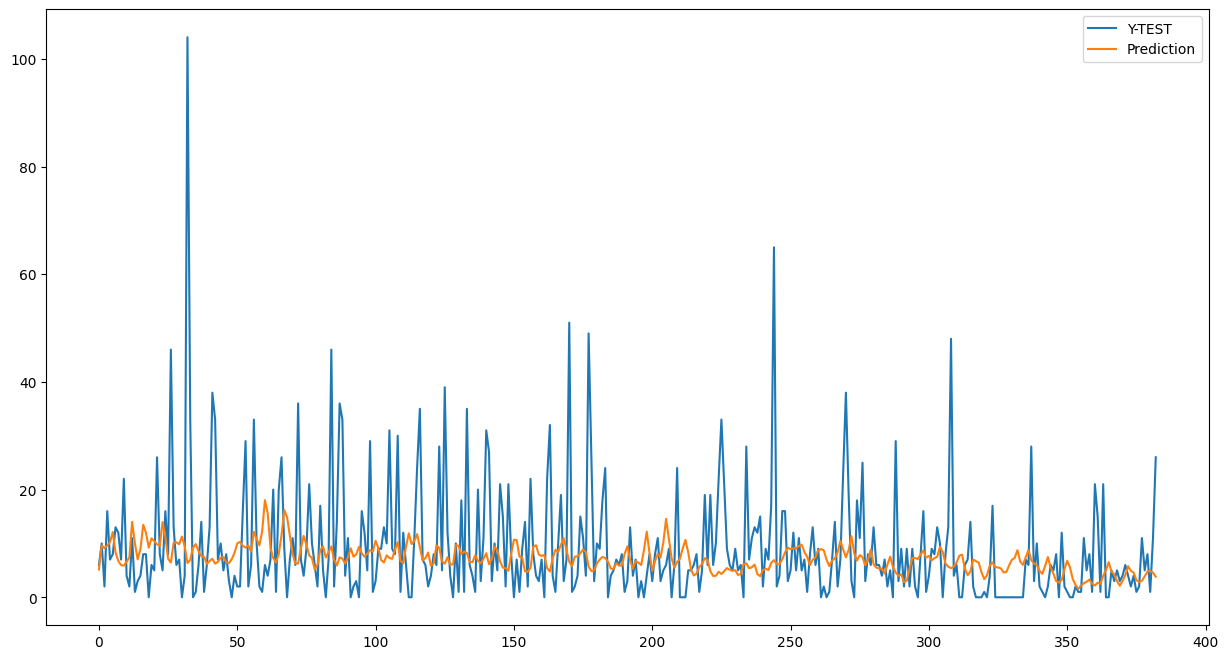

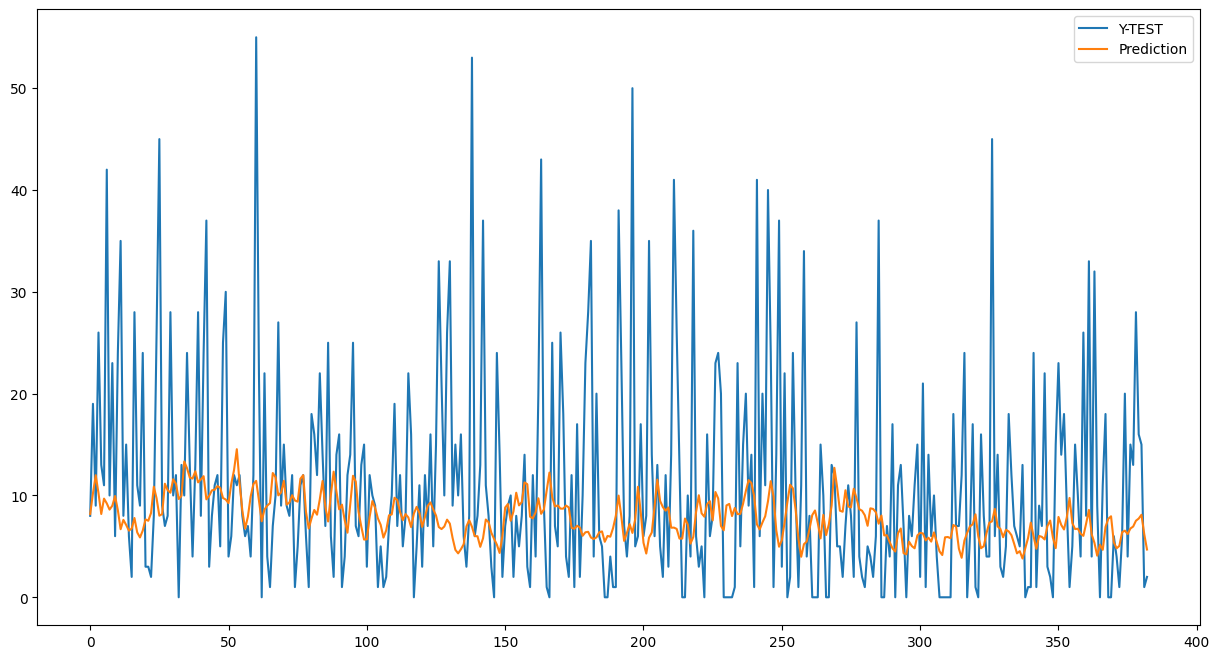

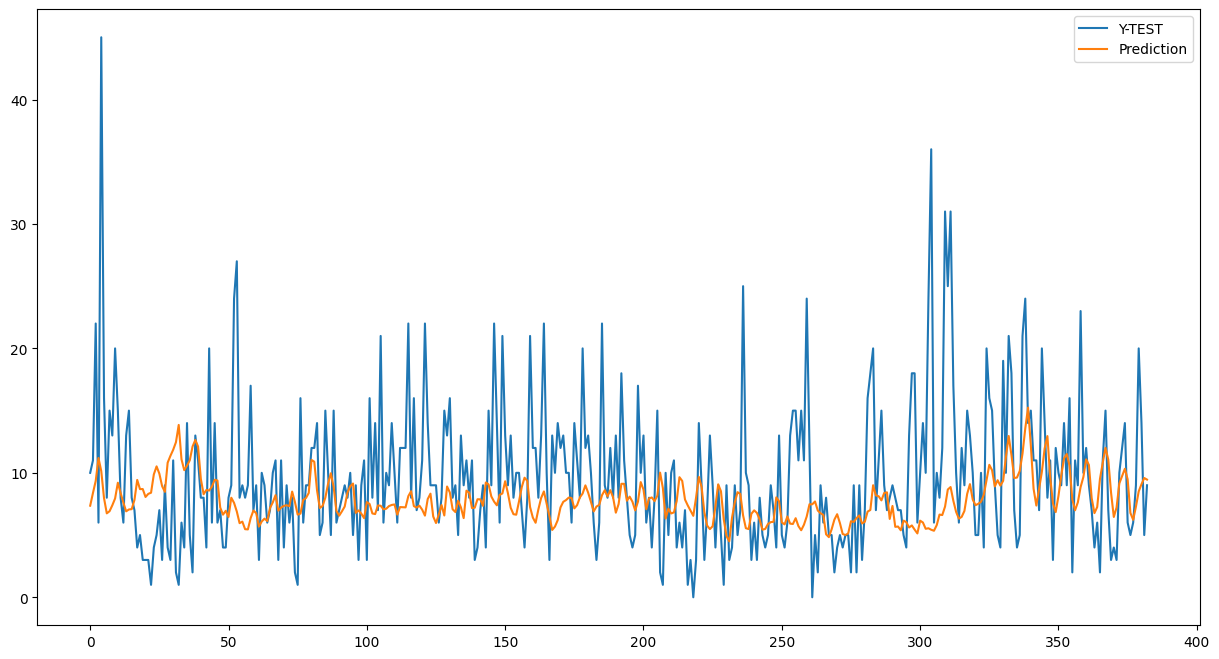

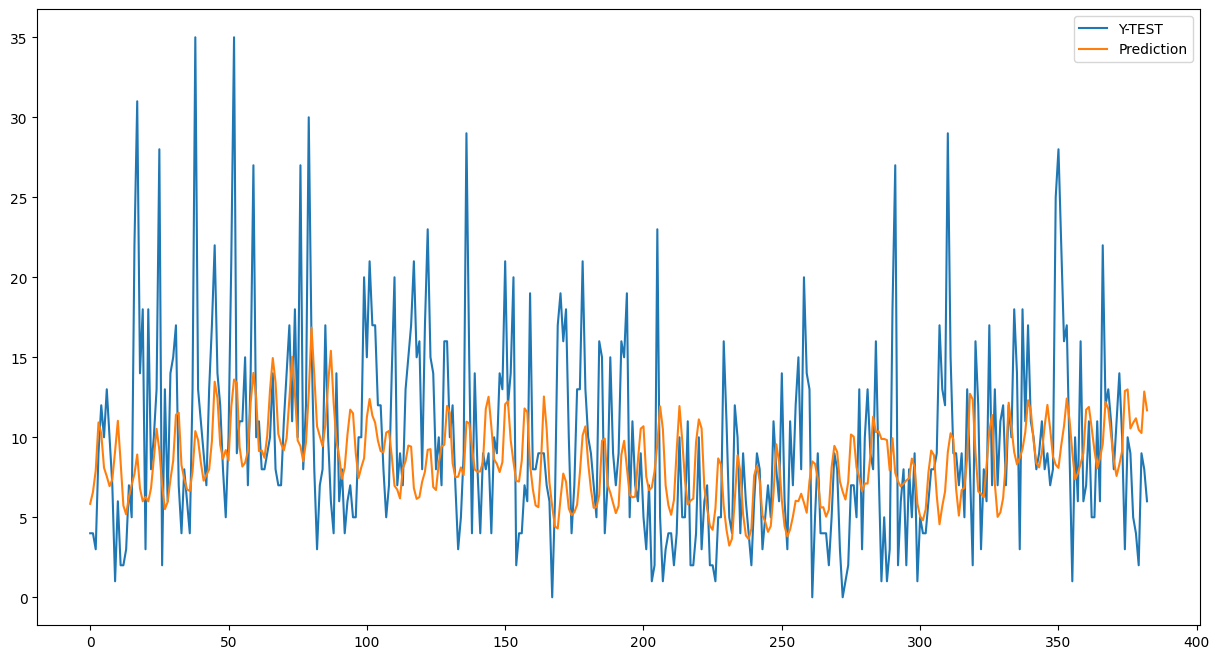

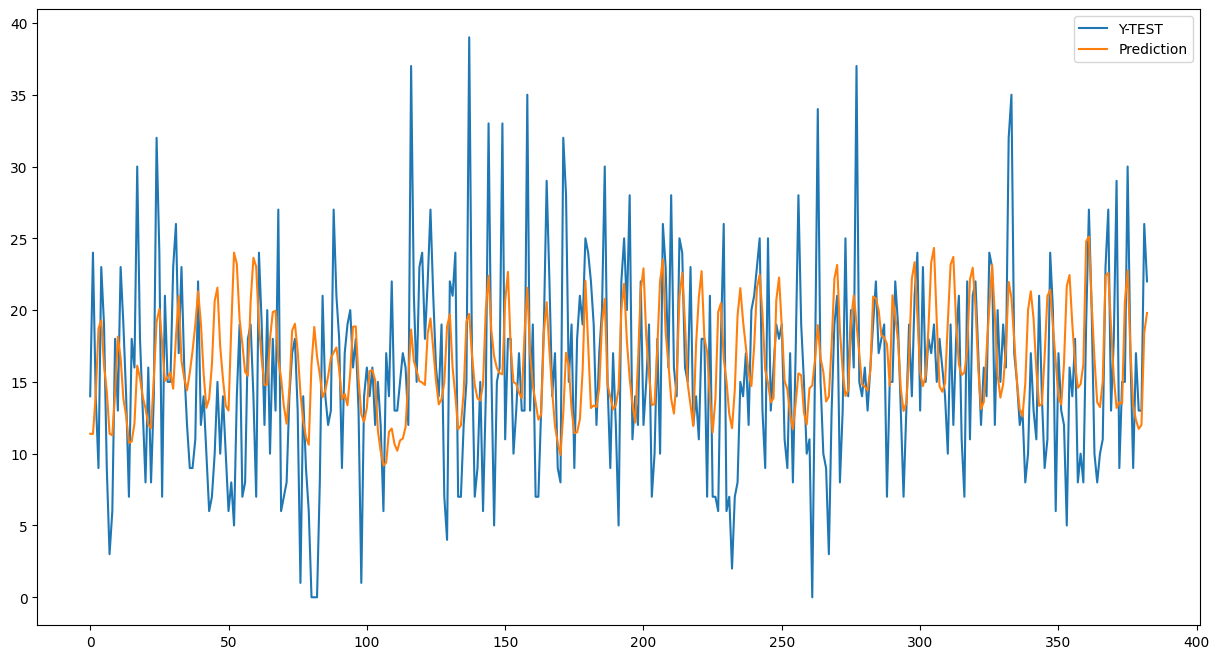

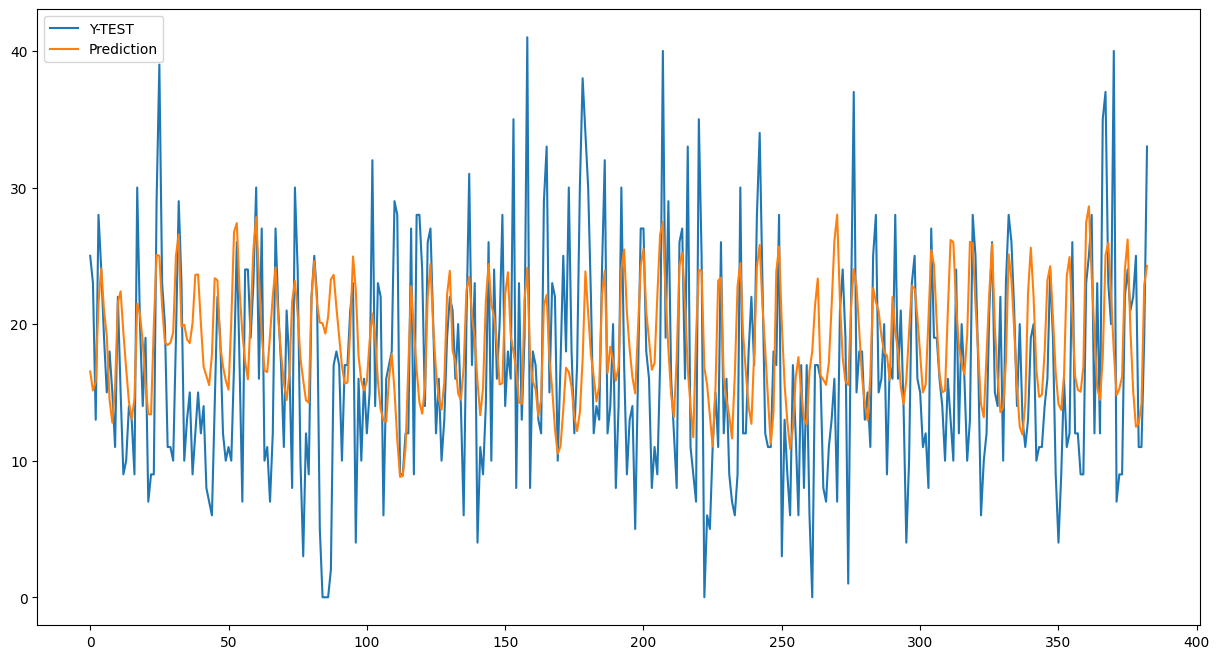

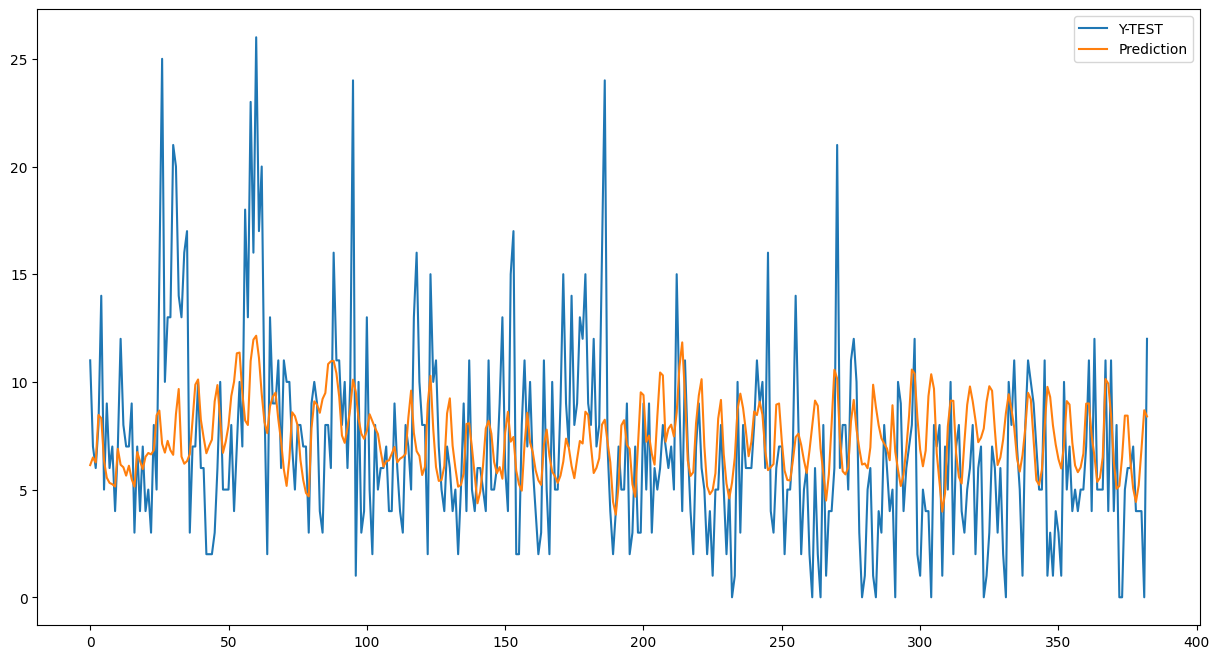

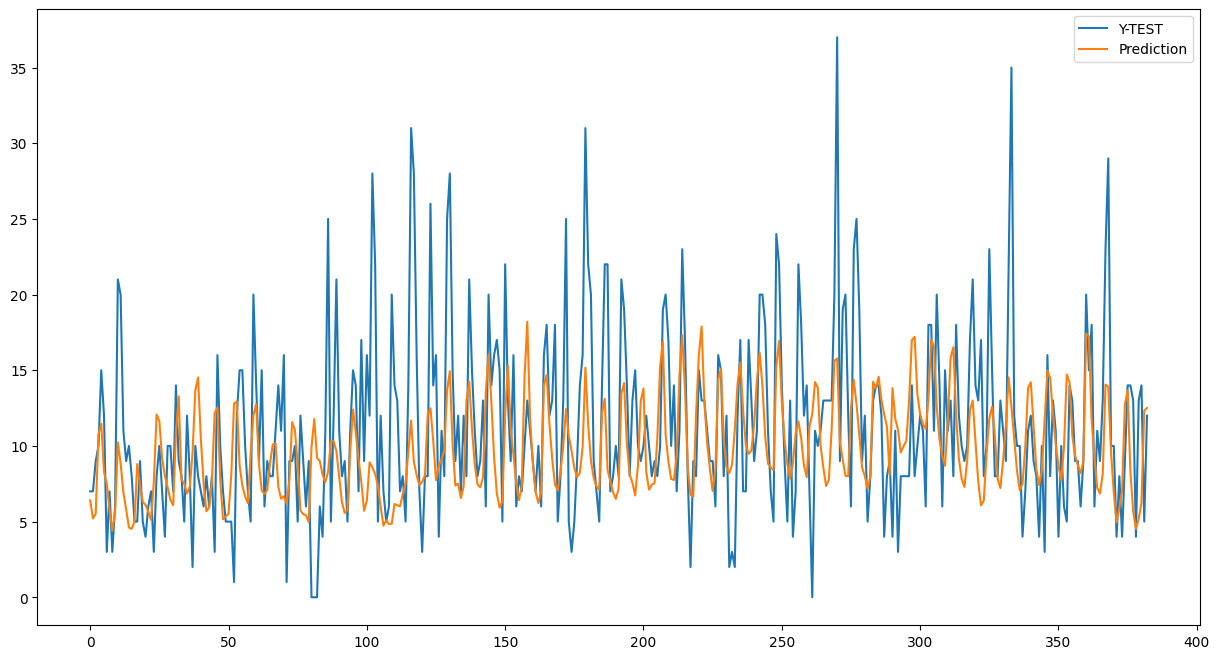

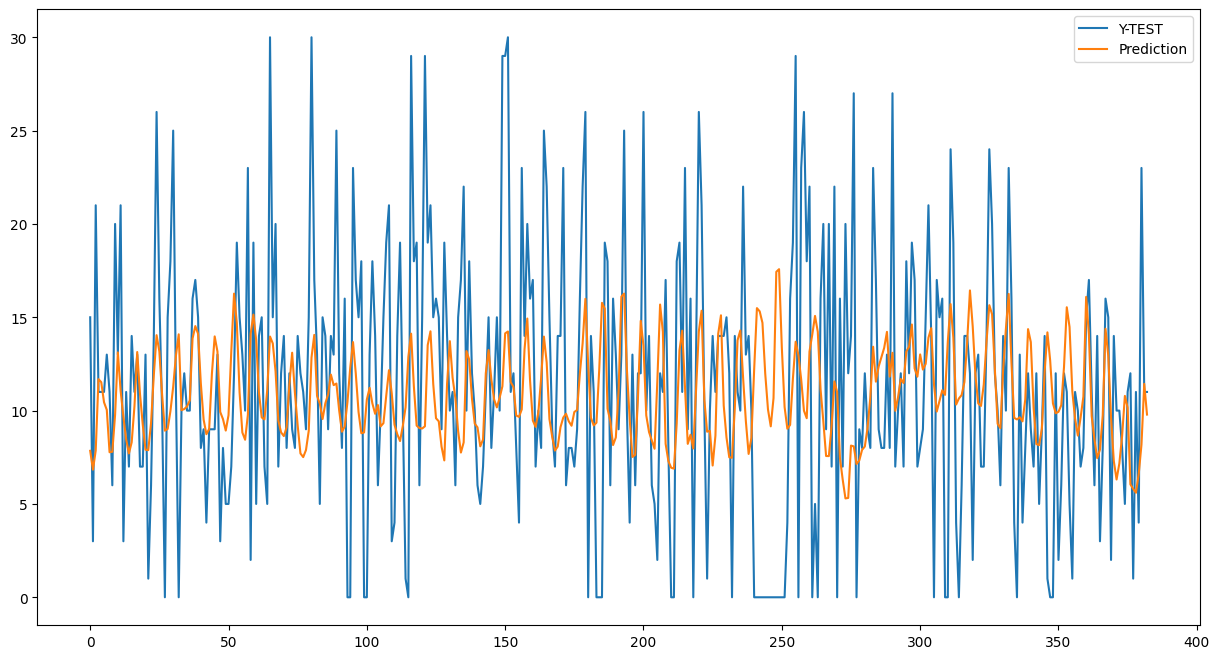

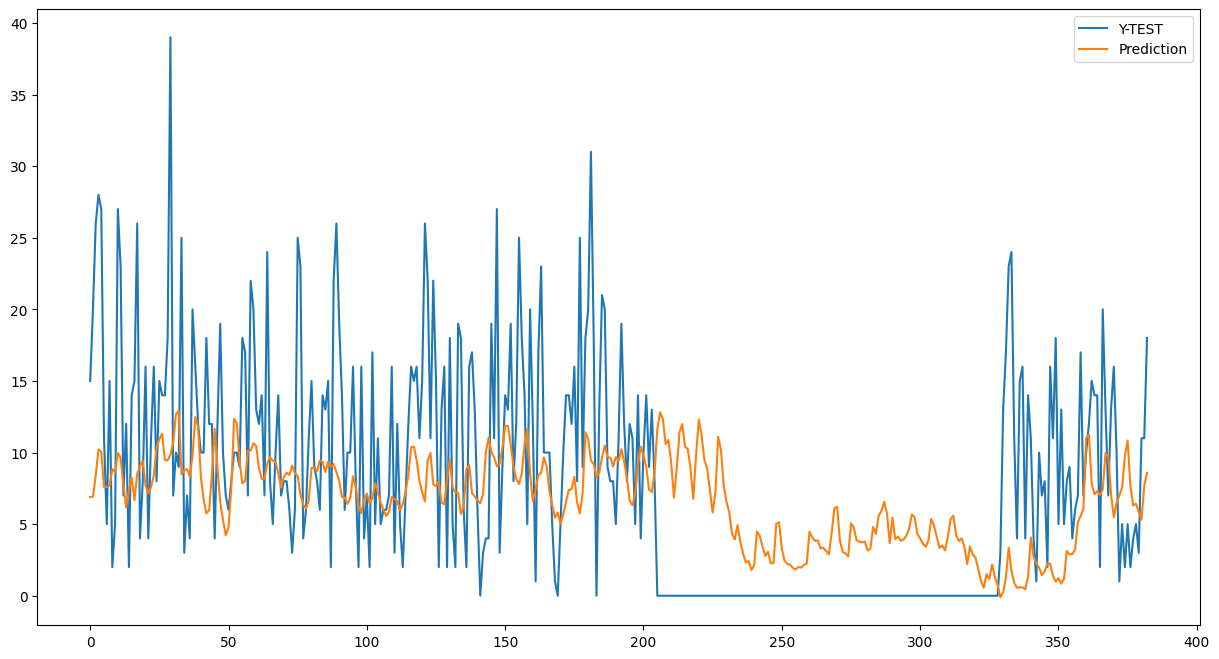

In [20]:
for i in range(10):
  plt.figure(figsize=(15,8))
  plt.plot(Ytest[:ln,i], label = "Y-TEST")
  plt.plot(predict[:ln,i], label = "Prediction")
  plt.legend()
  plt.show()

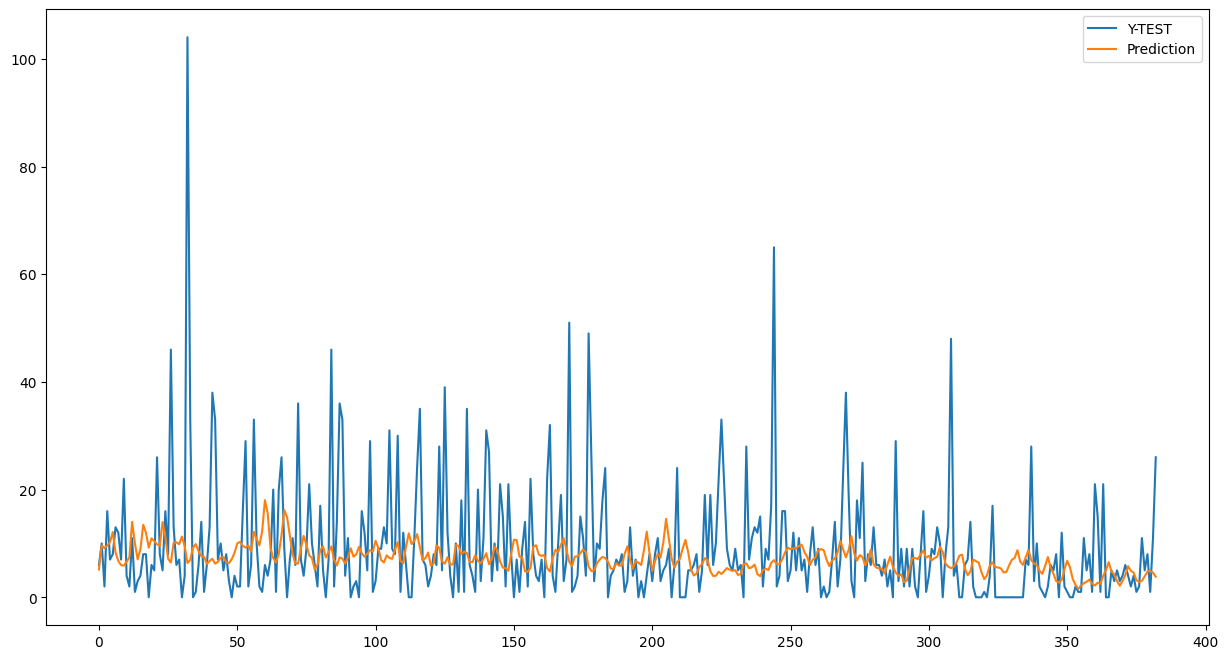

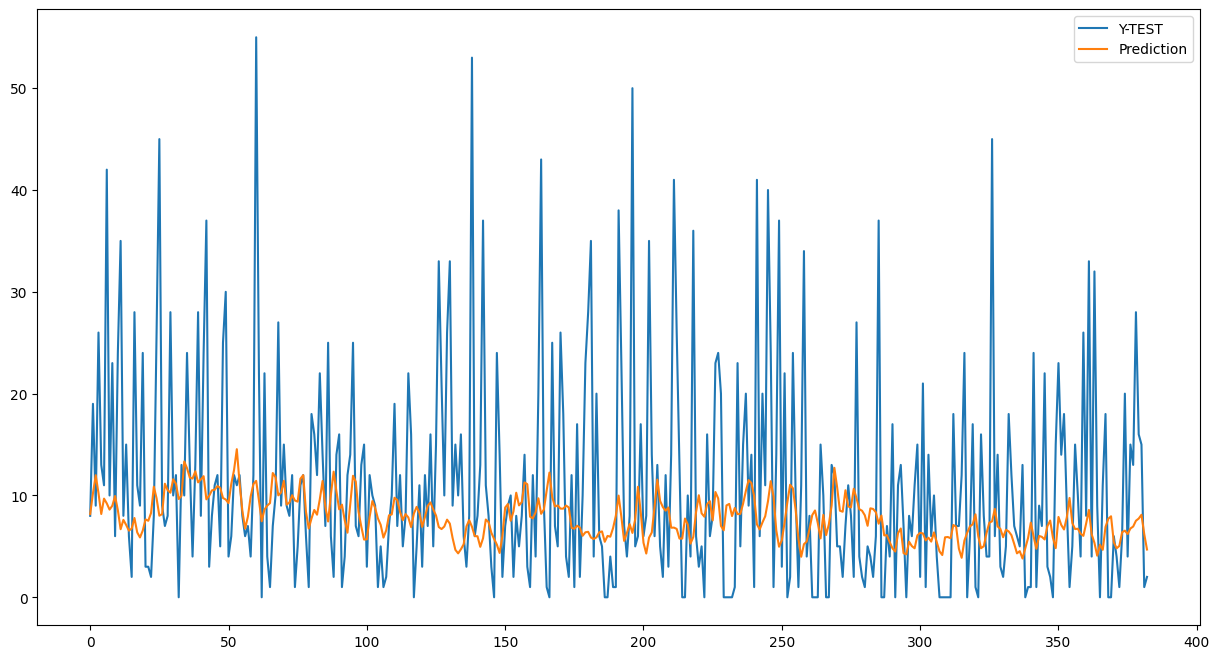

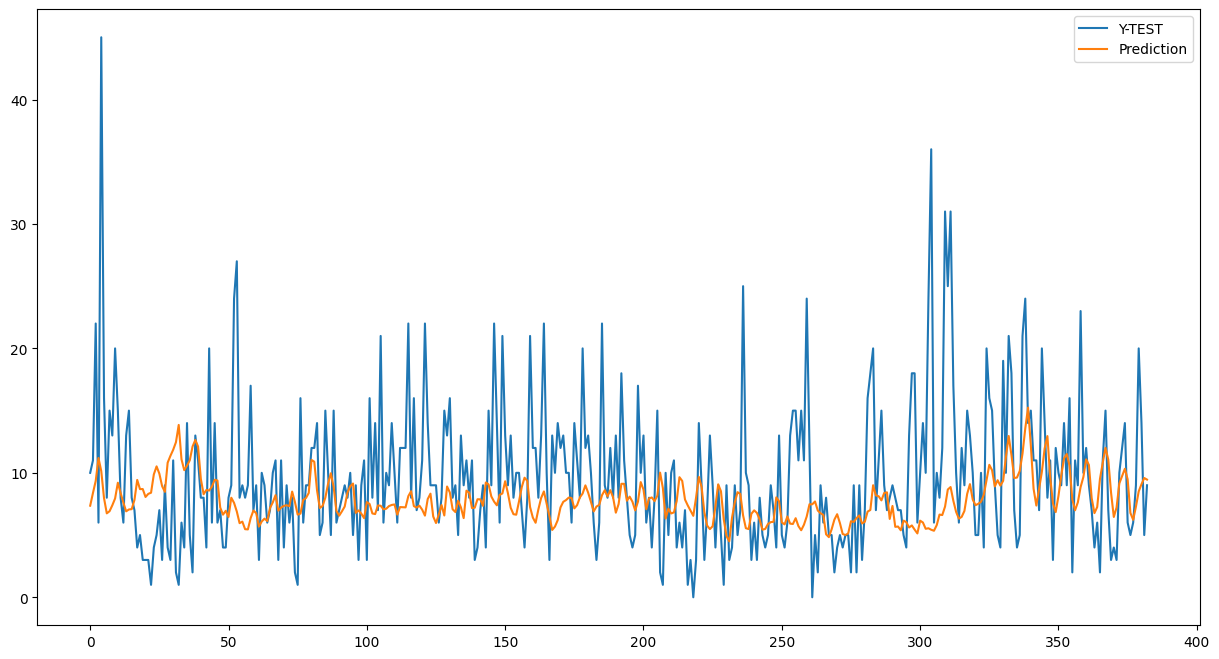

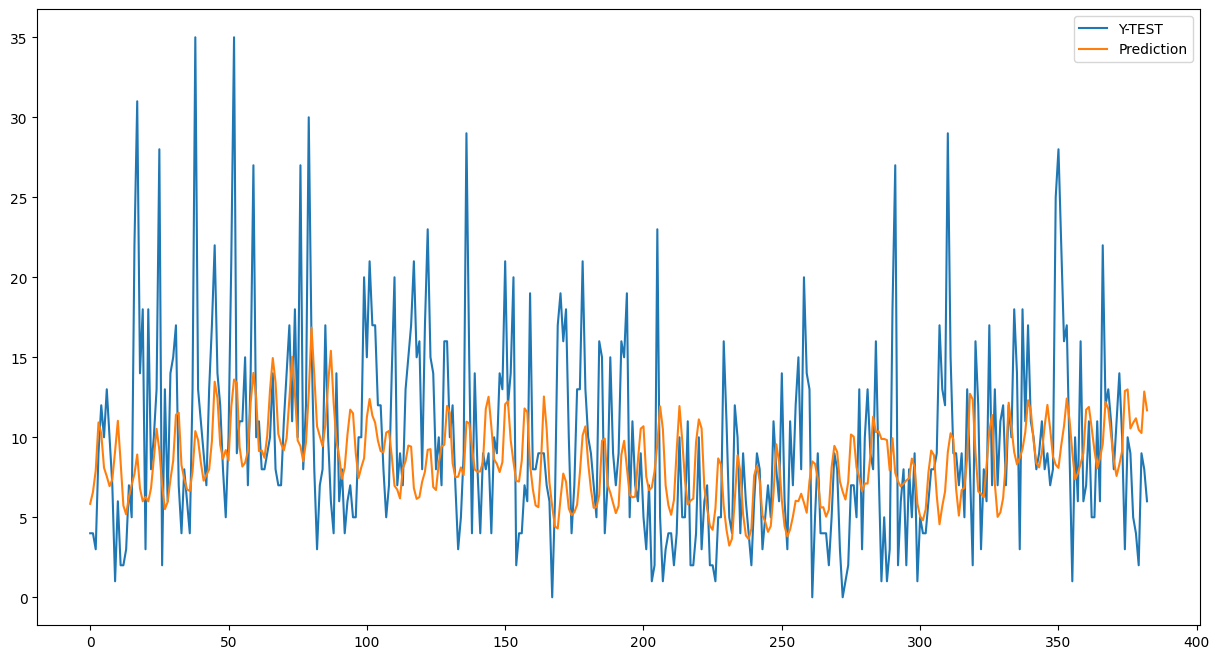

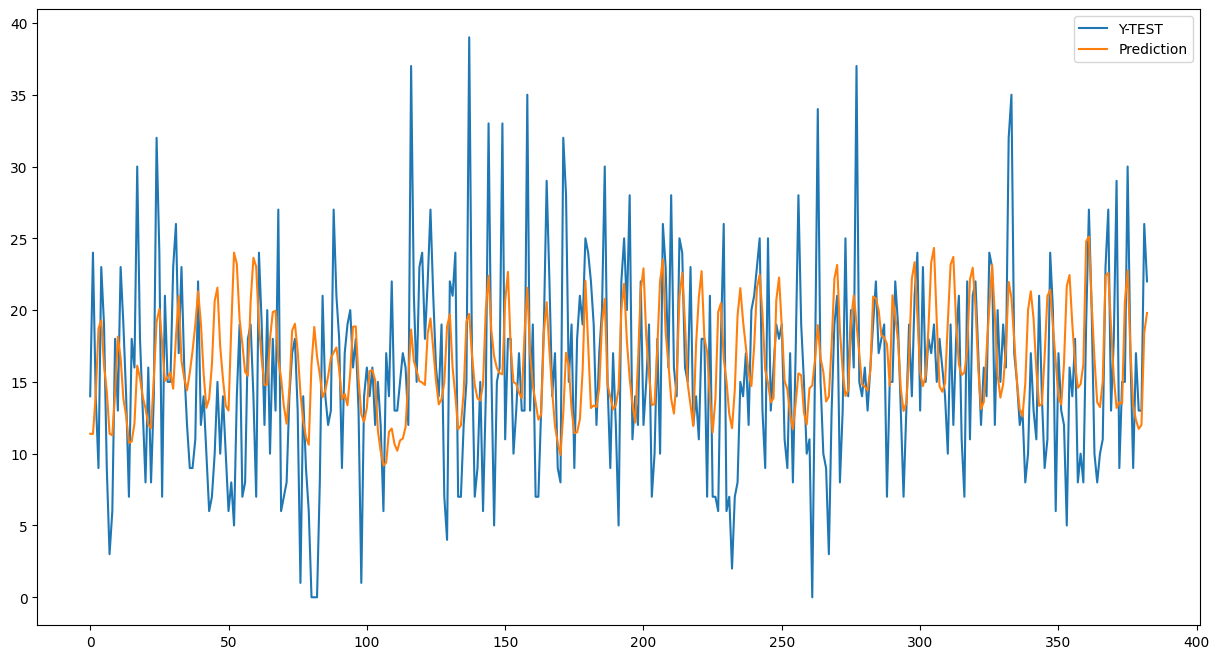

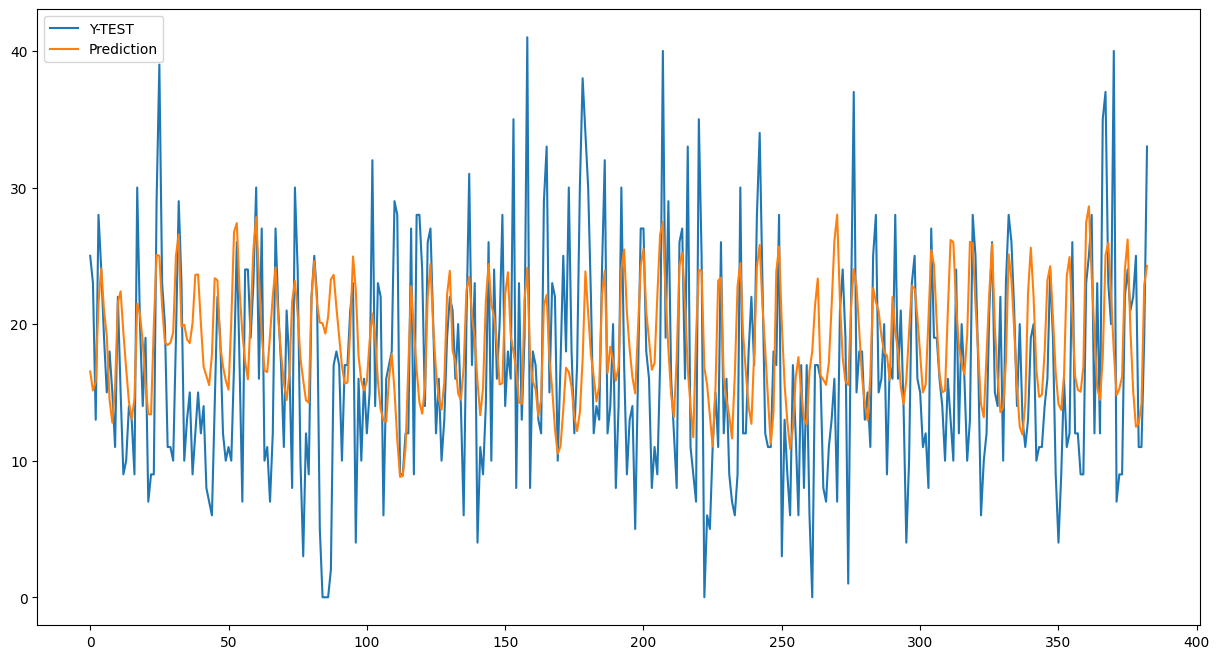

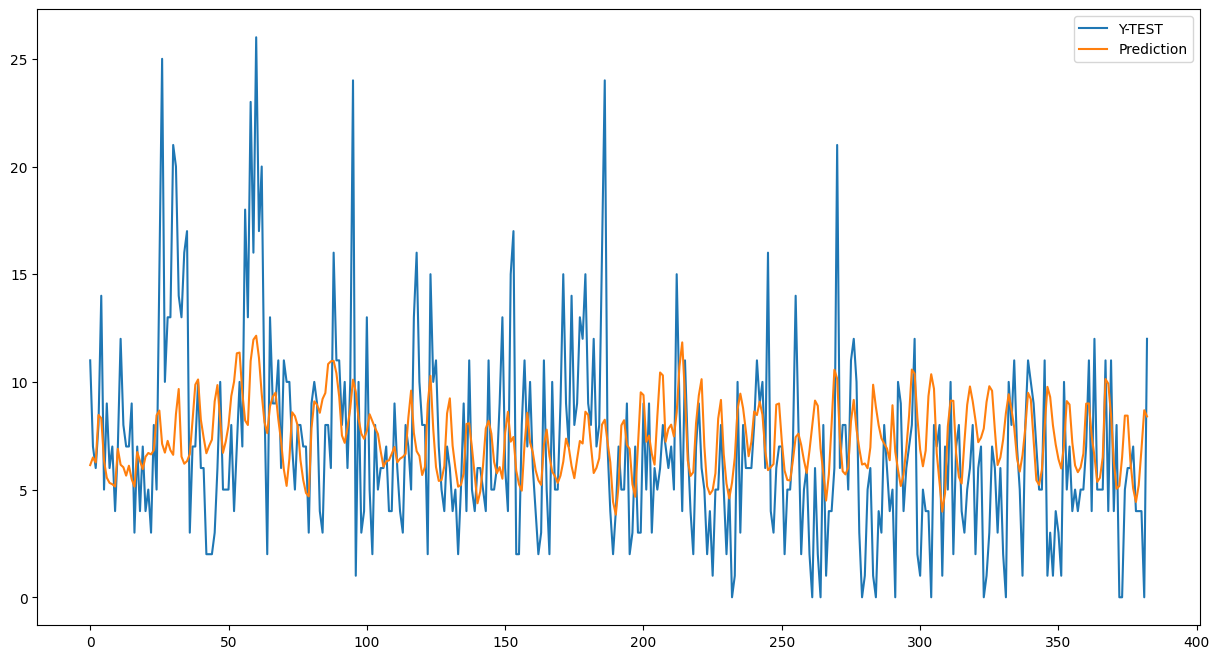

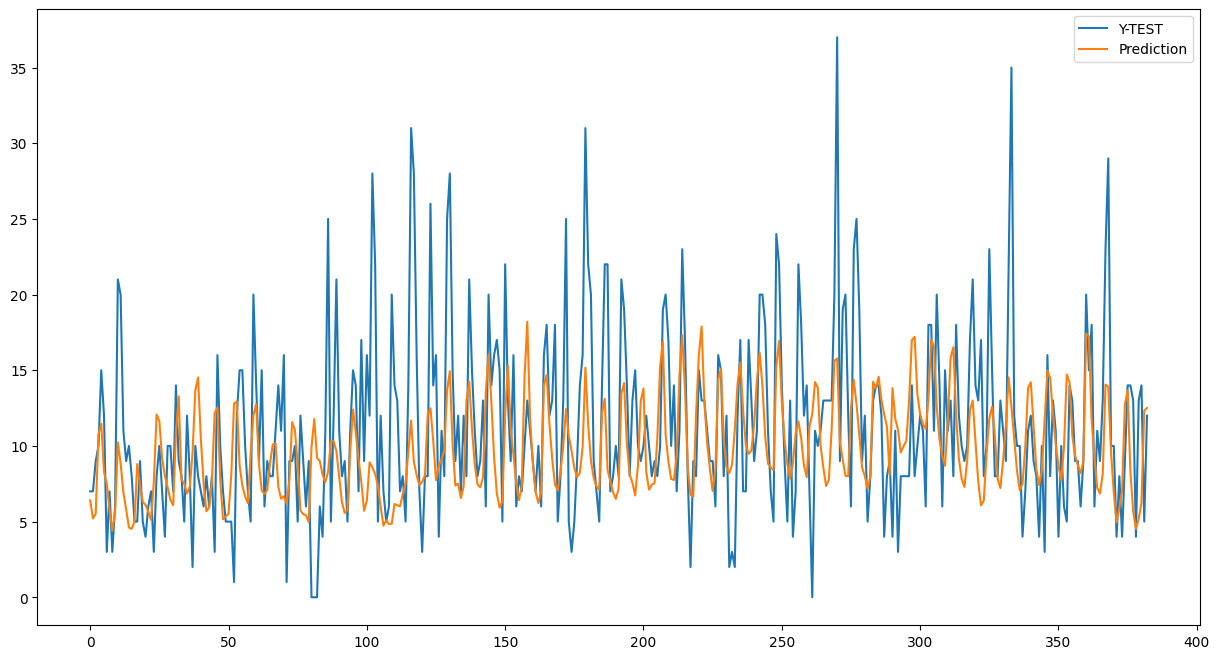

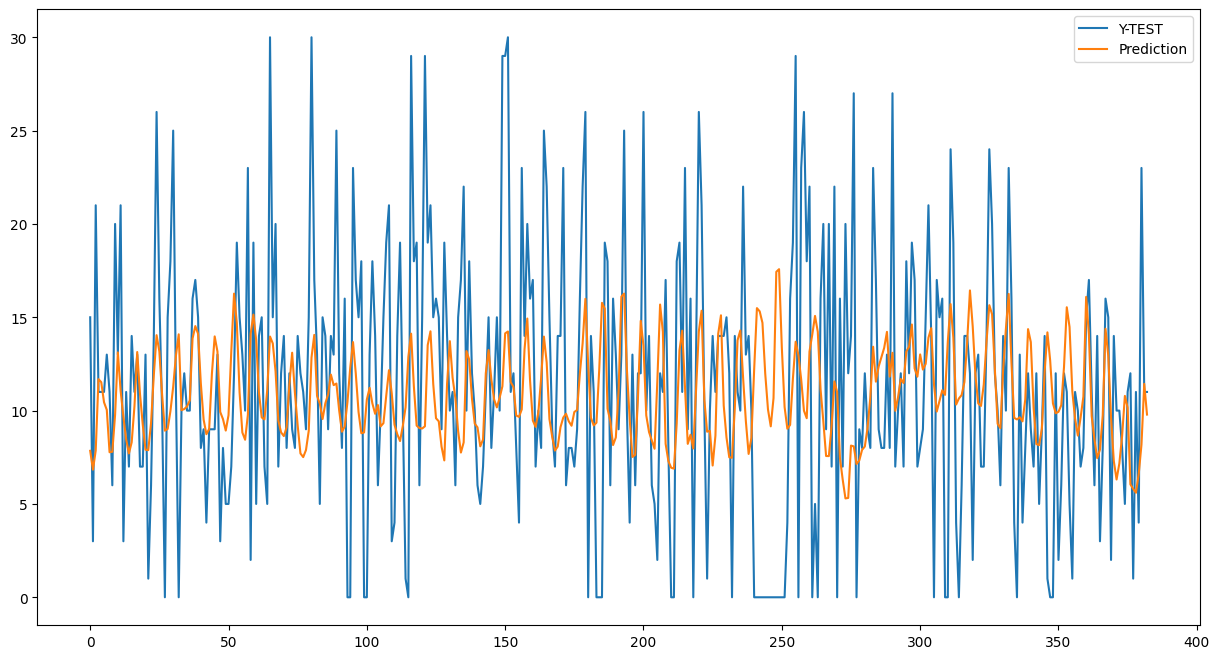

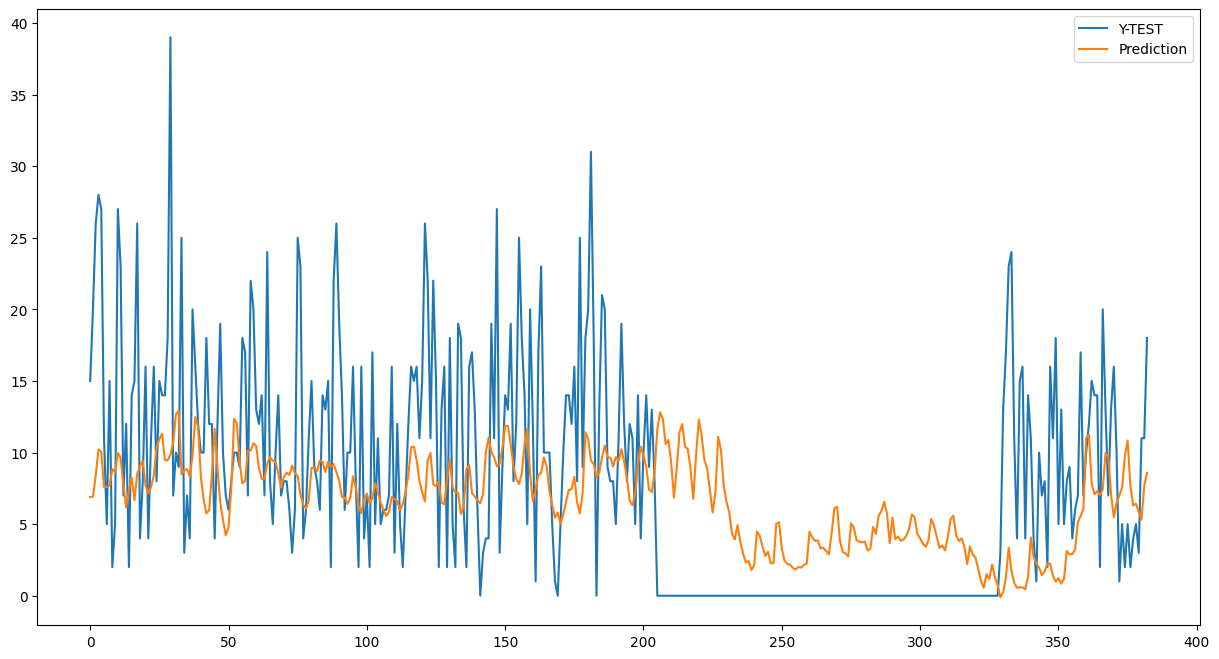

In [21]:
for i in range(10):
  plt.figure(figsize=(15,8))
  plt.plot(Ytest[:ln,i], label = "Y-TEST")
  plt.plot(predict[:ln,i], label = "Prediction")
  plt.legend()
  plt.show()

In [22]:
plt.plot_date

<function matplotlib.pyplot.plot_date(x, y, fmt='o', tz=None, xdate=True, ydate=False, *, data=None, **kwargs)>